### 1.기본 라이브러리 임포트

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2. 데이터 준비 및 어휘 사전 생성

In [3]:
# 단어 시퀀스 데이터 준비
words = ['나는', '학교에', '가고', '있다']
word_to_idx = {word: idx for idx, word in enumerate(words)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

print("word_to_idx:", word_to_idx)
print("idx_to_word:", idx_to_word)

word_to_idx: {'나는': 0, '학교에': 1, '가고': 2, '있다': 3}
idx_to_word: {0: '나는', 1: '학교에', 2: '가고', 3: '있다'}


### 3. 임베딩(Embedding) 레이어 생성

In [4]:
# 임베딩 차원 설정 (예: 5차원)
embedding_dim = 5
# 어휘 사전의 크기
vocab_size = len(words)

# PyTorch 임베딩 레이어 생성
# nn.Embedding(num_embeddings, embedding_dim)
embedding = nn.Embedding(vocab_size, embedding_dim)

### 4. 입력 시퀀스 생성

In [5]:
# 입력 시퀀스 (배치 크기 = 2)
# 1) "나는 학교에 가고 있다"
# 2) "학교에 가고 있다 나는"
input_sequence = [
    [word_to_idx['나는'], word_to_idx['학교에'], word_to_idx['가고'], word_to_idx['있다']],
    [word_to_idx['학교에'], word_to_idx['가고'], word_to_idx['있다'], word_to_idx['나는']]
]

# PyTorch 텐서로 변환
input_sequence_ = torch.tensor(input_sequence, dtype=torch.long)

print("input_sequence_:\n", input_sequence_)

input_sequence_:
 tensor([[0, 1, 2, 3],
        [1, 2, 3, 0]])


### 5. 입력 시퀀스를 임베딩

In [6]:
# (batch_size=2, sequence_length=4, embedding_dim=5)
embedded_sequence = embedding(input_sequence_)
print("embedded_sequence.shape:", embedded_sequence.shape)
print(embedded_sequence)

embedded_sequence.shape: torch.Size([2, 4, 5])
tensor([[[-0.8126, -1.0095,  0.5978,  1.1019,  0.1622],
         [-0.5456,  2.2800,  0.4656,  0.1444, -0.5779],
         [ 1.2927,  1.0273, -0.1111,  0.5597,  0.5014],
         [ 0.0761,  0.0315, -1.6356, -0.2700,  1.7215]],

        [[-0.5456,  2.2800,  0.4656,  0.1444, -0.5779],
         [ 1.2927,  1.0273, -0.1111,  0.5597,  0.5014],
         [ 0.0761,  0.0315, -1.6356, -0.2700,  1.7215],
         [-0.8126, -1.0095,  0.5978,  1.1019,  0.1622]]],
       grad_fn=<EmbeddingBackward0>)


### 6. 쿼리 벡터 생성

In [7]:
# 쿼리 벡터를 첫 번째 토큰의 임베딩으로 선택
# 첫 번째 문장: "나는", 두 번째 문장: "학교에"
# shape: (2, 5)
query = embedded_sequence[:, 0, :] #(batch_size, sequence_length, embedding_dim)
print("query.shape:", query.shape)
print(query)

query.shape: torch.Size([2, 5])
tensor([[-0.8126, -1.0095,  0.5978,  1.1019,  0.1622],
        [-0.5456,  2.2800,  0.4656,  0.1444, -0.5779]],
       grad_fn=<SliceBackward0>)


### 7. 간단한 어텐션(SimpleAttention) 레이어 구현


In [8]:
# Attention 학습 방법
# 1. Query, Key, Value 벡터 준비
#    - Query: 현재 디코더의 은닉 상태 (찾고자 하는 정보)
#    - Key: 인코더의 은닉 상태들 (참조할 정보)
#    - Value: 실제 입력 시퀀스의 정보

# 2. Attention Score 계산
#    - Query와 Key 사이의 유사도를 내적으로 계산
#    - 내적값이 클수록 두 벡터가 유사하며 해당 위치의 정보가 중요

# 3. Attention Weight 계산
#    - Score에 Softmax 적용하여 확률 분포로 변환
#    - 모든 가중치의 합이 1이 되도록 정규화

# 4. Context Vector 생성
#    - Attention Weight와 Value를 가중합하여 최종 Context Vector 생성
#    - 중요한 정보가 강조된 표현을 얻음

class SimpleAttention(nn.Module):
    def __init__(self, units):
        super(SimpleAttention, self).__init__()

        # units 인자는 Attention 메커니즘에서 사용할 은닉층의 크기를 지정합니다.
        # 이 값은 Query와 Key를 동일한 차원으로 변환할 때 사용됩니다.
        # Query와 Key를 동일한 차원(units)으로 변환하는 Layer
        self.W1 = nn.Linear(units, units)
        # Attention score를 1차원으로 압축하는 Layer
        self.W2 = nn.Linear(units, 1)

    def forward(self, query, values):
        """
        query: (batch_size, embedding_dim)
        values: (batch_size, seq_len, embedding_dim)
        """
        # 1) query에 시간축 차원 추가: (batch_size, 1, embedding_dim)
        query_with_time_axis = query.unsqueeze(1)

        # 2) 내적 기반 Attention Score 계산
        #    - query와 values 모두 W1 통과 → (batch_size, seq_len, units)
        #    - element-wise 곱(tanh) → (batch_size, seq_len, units)
        #    - W2를 거쳐 최종 score → (batch_size, seq_len, 1)
        score = self.W2(torch.tanh(self.W1(query_with_time_axis) * self.W1(values)))

        # 3) softmax로 가중치 계산 (seq_len 방향으로)
        attention_weights = F.softmax(score, dim=1)  # (batch_size, seq_len, 1)

        # 4) context vector = 가중치 * values의 가중합
        #    - (batch_size, seq_len, embedding_dim)
        context_vector = attention_weights * values
        #    - (batch_size, embedding_dim)
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector, attention_weights

# embedding_dim을 units로 사용하여 Query와 Key의 차원을 맞춤
# Query와 Key의 차원을 맞춰주는 이유:
# 1. Attention Score 계산 시 내적 연산을 수행하기 위해서는 두 벡터의 차원이 동일해야 함
# 2. SimpleAttention 클래스의 call() 메서드에서 self.W1을 통해 Query와 Key를 동일한 차원(units)으로 변환
# 3. 이후 변환된 벡터들의 내적으로 유사도를 계산하여 Attention Score를 얻음
# 따라서 embedding_dim을 units 파라미터로 사용하여 Query와 Key의 차원을 동일하게 맞춰줌


# embedding_dim = 5를 동일하게 사용
attention_layer = SimpleAttention(embedding_dim)

# 어텐션 레이어 적용
context_vector, attention_weights = attention_layer(query, embedded_sequence)

print("context_vector.shape:", context_vector.shape)     # (2, 5)
print("attention_weights.shape:", attention_weights.shape)  # (2, 4, 1)

context_vector.shape: torch.Size([2, 5])
attention_weights.shape: torch.Size([2, 4, 1])


### 8. 결과 확인 (어텐션 가중치)

In [10]:
print("\n=== 어텐션 결과 ===")
for i in range(2):
    print(f"\n문장 {i+1}의 각 단어에 대한 attention 가중치:")
    for j in range(len(words)):
        # attention_weights[i][j] == shape: (1,)
        weight = attention_weights[i][j].item()
        print(f"{idx_to_word[j]}: {weight:.3f}")



=== 어텐션 결과 ===

문장 1의 각 단어에 대한 attention 가중치:
나는: 0.312
학교에: 0.230
가고: 0.199
있다: 0.259

문장 2의 각 단어에 대한 attention 가중치:
나는: 0.160
학교에: 0.278
가고: 0.328
있다: 0.234


In [ ]:
print("\nAttention 가중치:")
for i in range(2):
    print(f"\n문장 {i+1}의 각 단어에 대한 attention 가중치:")
    for j, word in enumerate(words):
        weight = attention_weights[i][j].numpy()[0]
        print(f"{idx_to_word[j]}: {weight:.3f}")

### 9. nn.MultiheadAttention를 사용한 더 간단한 예시

#### 9.1 예시 문장 준비

In [11]:
# 새로운 단어 목록
words = ['cat', 'saw', 'fish', 'in', 'the', 'pond', 'and', 'decided', 'to', 'catch']
word_to_idx = {word: idx for idx, word in enumerate(words)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# 2개 문장으로 구성된 입력 시퀀스
# 첫 번째 문장: cat saw fish in the pond and decided to catch
# 두 번째 문장: fish in the pond and decided to catch catch catch
input_sequence = torch.tensor([
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [2, 3, 4, 5, 6, 7, 8, 9, 9, 9]
], dtype=torch.long)

print("input_sequence:\n", input_sequence)

input_sequence:
 tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [2, 3, 4, 5, 6, 7, 8, 9, 9, 9]])


#### 9.2. 임베딩

In [12]:
embedding_dim = 10
embedding_layer = nn.Embedding(num_embeddings=len(words), embedding_dim=embedding_dim)

embedded_sequence = embedding_layer(input_sequence)
print("embedded_sequence.shape:", embedded_sequence.shape)  # (batch_size=2, seq_len=10, embedding_dim=10)

embedded_sequence.shape: torch.Size([2, 10, 10])


#### 9.3. Query 벡터 생성

In [13]:
# 임의의 쿼리 벡터 (batch_size=2, embedding_dim=10)
query = torch.randn(2, embedding_dim)
print("query.shape:", query.shape)

query.shape: torch.Size([2, 10])


#### 9.4. nn.MultiheadAttention 사용

In [14]:
# PyTorch의 nn.MultiheadAttention는 입력 텐서의 shape을
# (sequence_length, batch_size, embedding_dim) 형태로 받습니다.
# batch_first=True 옵션을 주면
# (batch_size, sequence_length, embedding_dim) 형태로도 가능합니다.

# 아래 예시에서는 batch_first=True를 사용해
# 우리의 입력 shape인 (2, 10, 10)을 그대로 처리할 수 있게 합니다.

# MultiheadAttention 예시 (단일 헤드 사용)
multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=1, batch_first=True)

# 쿼리도 shape을 (2, 1, 10)으로 만들어서 입력 (batch_size=2, seq_len_q=1, embed_dim=10)
query_with_time_axis = query.unsqueeze(1)

# 여기서는 Query, Key, Value를 모두 같은 임베딩 시퀀스로 사용(자기 자신에 대한 어텐션, Self-Attention 형태)
attn_output, attn_weights = multihead_attn(query_with_time_axis, embedded_sequence, embedded_sequence)


# attn_output
# (batch_size, seq_len_q, embed_dim)
# 현재는 쿼리 길이가 1이므로 (2, 1, 10)

# attn_weights
# (batch_size, seq_len_q, seq_len_k)
# 가중치는 한 문장(길이 1)에서 각 Key 토큰(길이 10)으로 분산된 값
# 따라서 (2, 1, 10)

print("attn_output.shape:", attn_output.shape)    # (batch_size=2, seq_len_q=1, embed_dim=10)
print("attn_weights.shape:", attn_weights.shape)  # (batch_size=2, seq_len_q=1, seq_len_k=10)

attn_output.shape: torch.Size([2, 1, 10])
attn_weights.shape: torch.Size([2, 1, 10])


#### 9.5. 어텐션 가중치 시각화

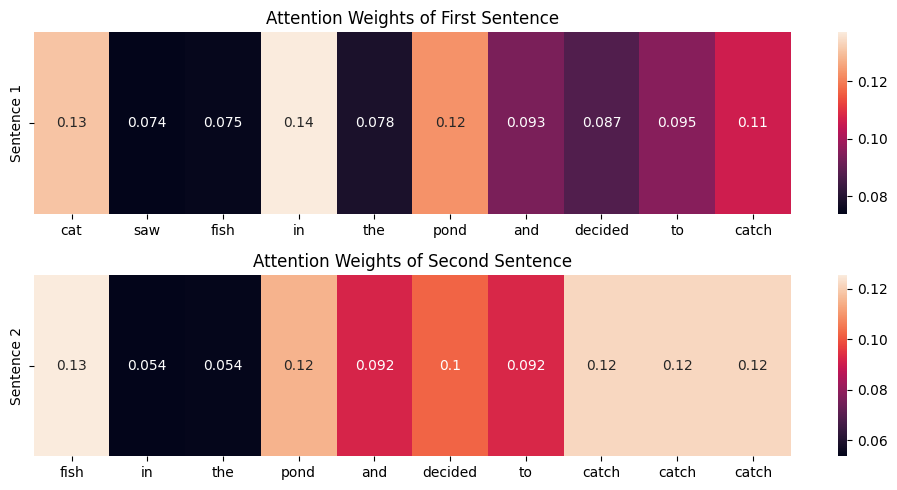

In [ ]:
# 2차원으로 shape을 줄여서 (2, 10)
# 문장이 2개, 각 문장에 대해 10개 단어의 가중치
attn_weights_2d = attn_weights.squeeze(1)  # (2, 10)

plt.figure(figsize=(10, 5))

# 첫 번째 문장 어텐션 가중치
plt.subplot(2, 1, 1)
sns.heatmap(
    attn_weights_2d[0].unsqueeze(0).detach().numpy(),
    # xticklabels=[idx_to_word[i] for i in input_sequence[0]], <- PyTorch 텐서는 일반 파이썬의 정수가 아니므로, item() 메서드로 텐서 값을 정수로 꺼내 딕셔너리에 접근해야 합니다.
    xticklabels=[idx_to_word[i.item()] for i in input_sequence[0]],
    yticklabels=['Sentence 1'],
    annot=True
)
plt.title('Attention Weights of First Sentence')

# 두 번째 문장 어텐션 가중치
plt.subplot(2, 1, 2)
sns.heatmap(
    attn_weights_2d[1].unsqueeze(0).detach().numpy(),
    # xticklabels=[idx_to_word[i] for i in input_sequence[1]], <- PyTorch 텐서는 일반 파이썬의 정수가 아니므로, item() 메서드로 텐서 값을 정수로 꺼내 딕셔너리에 접근해야 합니다.
    xticklabels=[idx_to_word[i.item()] for i in input_sequence[1]],
    yticklabels=['Sentence 2'],
    annot=True
)
plt.title('Attention Weights of Second Sentence')

plt.tight_layout()
plt.show()

히트맵 시각화 결과 분석

1. 두 문장의 Attention 가중치가 비슷한 패턴을 보이는 이유:
   - 현재 구현된 기본 Attention 모델은 단순히 단어 임베딩 간의 유사도만을 계산
   - 문맥적 정보나 위치 정보를 고려하지 않음
   - 실제 자연어의 문맥적 의미를 충분히 반영하지 못함
2. 개선 방안:
   - Positional Encoding을 추가하여 단어의 위치 정보 반영
   - Self-Attention 메커니즘 도입
   - Multi-head Attention 사용으로 다양한 관점에서의 관계 파악


#### 텐서플로우와 파이토치가 가중치를 초기화 해주는 방식이 달라서 입니다! 초기 가중치가 다르기에 서로 다르게 나올 수 있습니다 🙂